In [1]:
# Found at:
# https://medium.com/towards-data-science/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## The Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [3]:
data = pd.read_parquet('data/2_featured/tripfeatures.parquet')
data.columns = [col.lower().replace('_', ' ') for col in data.columns]
print(data.shape)
print(list(data.columns))

(5671033, 5)
['is subscriber', 'gender', 'tripduration', 'customer age', 'trip distance in m']


In [4]:
data.head()

,is subscriber,gender,tripduration,customer age,trip distance in m
0,1,1,241,48,888
1,1,1,764,24,2641
2,1,2,1515,42,4653
3,1,1,1034,24,2187
4,1,2,837,27,2006


### Create dummy variables

In [5]:
data['is subscriber'].value_counts()

1    5164627
0     506406
Name: is subscriber, dtype: int64

In [6]:
data['gender'].value_counts()

1    3955871
2    1260893
0     454269
Name: gender, dtype: int64

In [7]:
cat_vars=['gender']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
    
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]
data_final.columns.values

# Remove base categories
data_final = data_final.drop('gender_1', axis=1) # set males as base category

In [8]:
data_final.head()

,is subscriber,tripduration,customer age,trip distance in m,gender_0,gender_2
0,1,241,48,888,0,0
1,1,764,24,2641,0,0
2,1,1515,42,4653,0,1
3,1,1034,24,2187,0,0
4,1,837,27,2006,0,1


### Over-sampling using SMOTE

In [9]:
X = data_final.loc[:, data_final.columns != 'is subscriber']
y = data_final.loc[:, data_final.columns == 'is subscriber']

In [10]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
y_train, y_test = y_train.astype('int'), y_test.astype('int')

os = SMOTE(random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['is subscriber'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['is subscriber']==0]))
print("Number of subscription",len(os_data_y[os_data_y['is subscriber']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['is subscriber']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['is subscriber']==1])/len(os_data_X))

length of oversampled data is  7747984
Number of no subscription in oversampled data 3873992
Number of subscription 3873992
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


### Implementing the model

In [11]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classified = classifier.fit(X_train, y_train.to_numpy().ravel())

In [12]:
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)

### Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[  89351   37773]
 [  24212 1266423]]


In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74    127124
           1       0.97      0.98      0.98   1290635

    accuracy                           0.96   1417759
   macro avg       0.88      0.84      0.86   1417759
weighted avg       0.95      0.96      0.96   1417759



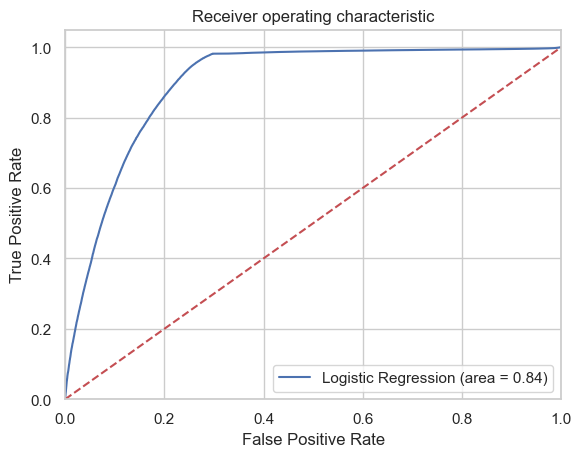

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [16]:
coefficients = list(zip(classified.feature_names_in_, classified.coef_.ravel()))
for key, val in coefficients:
    print(f"{key}: {val}")

tripduration: -1.305438357899657e-05
customer age: 0.0428934182466665
trip distance in m: -0.00013830434131143632
gender_0: -5.529081634900841
gender_2: -0.6615221661745002
